In [29]:
################################################################################
# Packages
################################################################################

library(pheatmap)
library(tidyverse)
library(glue)
library(DESeq2)

################################################################################
# Data directory
################################################################################

data_directory = 'Figure6_data'

################################################################################
# Functions
################################################################################

# Extract subset: 
#
# Takes a dataframe or DeSeq2 object ('input') and extracts a subset of 
# elements depending on 'mode'. 'gene' extracts genes, 'TE' extracts all annotated repeats,
# and 'ERE' extracts endogenous retroelements (i.e. LTRs, LINEs, SINEs).

extract_subset = function(mode, input){
  
  if (mode == 'gene'){
    
    output = input[grep("^ENSG",rownames(input)),]
    
  }
  
  if (mode == 'TE'){
    
    output = input[grepl("^(?!ENSG).*$",rownames(input), perl = TRUE),]
    
  }
  
  if (mode == 'ERE'){
    
    output = input[grepl("^(?!ENSG).*$",rownames(input), perl = TRUE),]
    output = output[!grepl("Satellite",rownames(output), perl = TRUE),]
    output = output[!grepl("DNA",rownames(output), perl = TRUE),]
    output = output[!grepl("RNA",rownames(output), perl = TRUE),]
    output = output[!grepl("Unknown",rownames(output), perl = TRUE),]
    output = output[!grepl("RC",rownames(output), perl = TRUE),]
    
  }
  
  if (mode == 'ereMAP'){
    
    ereMAP_loci = readRDS('~/Desktop/thymus-epitope-mapping/ERE-analysis/analysis/R_variables/ereMAP_loci')
    output = input[rownames(input) %in% ereMAP_loci, ]
    
  }
  
  return(output)
  
}

# Differential expression: 
#
# Generates a DESeq2 dds object.  Requires the input count table to have entries
# in the format '{unique ID}_{tissue}_{batch}'. By default, design 
# detects differences between tissues. For differential expression analysis 
# between mTEC-HI and -LO samples, you'll want to change the design to
# '~patient + tissue', but this can't be done when including GTEx data. After
# producing the dds object, filters lowly expressed genes/TEs by requiring
# a minimum number of reads (default 2) in a row.

differential_expression = function(raw_count_table, min_reads = 2, design = ~tissue){
  
  ## Define sampleInfo
  
  ID = colnames(raw_count_table)
  sampleInfo = data.frame(ID,row.names=colnames(raw_count_table))
  sampleInfo = suppressWarnings(separate(sampleInfo, col = ID, into = c('patient', 'tissue', 'batch'), sep = '_'))
  sampleInfo$patient = factor(sampleInfo$patient)
  
  ## Construct DESeq dataset object
  
  dds <- DESeqDataSetFromMatrix(countData = raw_count_table, colData = sampleInfo, design = design)
  
  ## Run differential expression analysis
  
  dds = DESeq(dds)
  
  ## Pre-filter to remove rows with less than 'min_reads' total (default 2)
  
  dds = dds[ rowSums(counts(dds)) >= min_reads, ]
  
  return(dds)
  
}

# Process DESeq2 results: 

process_DESeq2_results = function(results, mode, p_value_cutoff = 0.05, log_fold_change_cutoff = 0.58){
  
  ## Add statistical and biological significance labels
  
  results_df = as.data.frame(results)
  
  results_df = mutate(results_df, significant = case_when(padj < p_value_cutoff ~ TRUE, 
                                                          padj >= p_value_cutoff ~ FALSE))
  
  results_df = mutate(results_df, FC_significant = case_when(abs(log2FoldChange) > log_fold_change_cutoff ~ TRUE, 
                                                             abs(log2FoldChange) <= log_fold_change_cutoff ~ FALSE))
  
  results_df = mutate(results_df, overall_significant = case_when((significant == TRUE) & (FC_significant == TRUE) ~ TRUE, 
                                                                  (significant == FALSE) | (FC_significant == FALSE) ~ FALSE))
  
  ## Add separate ID columns
  
  if (mode == 'TE_transcripts'){
    
    results_df = cbind(ID = rownames(results_df), results_df)
    results_df = separate(data = results_df, col = 'ID', into = c('gene', 'family', 'class'), sep = ':')
    results_df = cbind(ID = rownames(results_df), results_df)
    
  }
  
  if (mode == 'TE_local'){
    
    results_df = cbind(ID = rownames(results_df), results_df)
    results_df = separate(data = results_df, col = 'ID', into = c('locus', 'gene', 'family', 'class'), sep = ':')
    results_df = cbind(ID = rownames(results_df), results_df)
    
  }
  
  if (mode == 'Gene'){
    
    results_df = cbind(Geneid = rownames(results_df), results_df)
    
  }
  
  if (mode == 'Salmon'){
    
    #results_df = cbind(Geneid = rownames(results_df), results_df)
    
  }
  
  return(results_df)
  
}


**Figure 6A**

In [23]:
################################################################################
# Import TPM values from SalmonTE
################################################################################

TPM = read.csv(glue("{data_directory}/TPM.csv"))

row.names(TPM) = TPM$TE
TPM = select(TPM, -TE)
TPM = TPM[rowSums(TPM) >= 2, ]

for (i in 1:length(colnames(TPM))){
  
  if (grepl('ESC', colnames(TPM)[i])){
    
    current_name = colnames(TPM)[i]
    colnames(TPM)[i] = glue::glue('{current_name}_SRA')
    
  }
  
  if (grepl('mTEC', colnames(TPM)[i])){
    
    current_name = colnames(TPM)[i]
    colnames(TPM)[i] = glue::glue('{current_name}_ours')
    
  }
  
  else if (!(grepl('ESC', colnames(TPM)[i]))){
    
    current_name = colnames(TPM)[i]
    
    colnames(TPM)[i] = glue::glue('{current_name}_GTEx')
    
  }
  
}

ID = colnames(TPM)
sampleInfo = data.frame(ID,row.names=colnames(TPM))
sampleInfo = suppressWarnings(separate(sampleInfo, 
                                       col = ID, 
                                       into = c('patient', 'tissue', 'batch'), 
                                       sep = '_'))
sampleInfo$ID = row.names(sampleInfo)

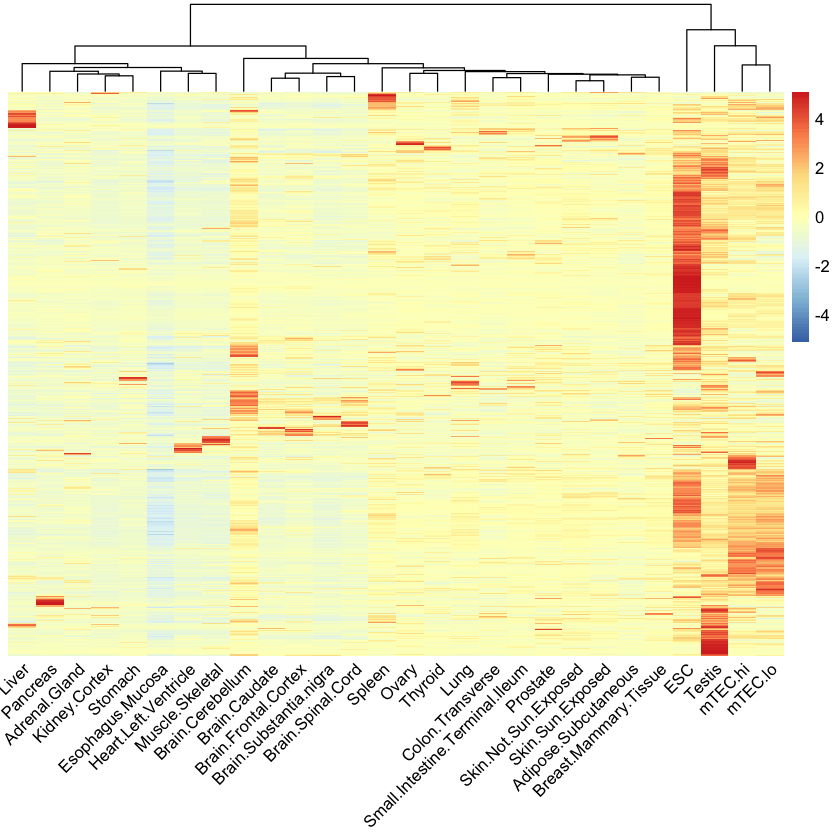

In [24]:
################################################################################
# Heatmap
################################################################################

## Collapse tissue replicates

counter = 1
for (i in (unique(sampleInfo$tissue))){

  samples = subset(sampleInfo, tissue == i)$ID
  
  entry = rowMeans(TPM[ , colnames(TPM) %in% samples])
  
  if (counter == 1){
    
    output = data.frame('placeholder' = entry)
    names(output) = i
    
  }
  
  else{
    
    output[i] = entry
    
  }
  
  counter = counter + 1
  
}

averaged_TPM = output

## Plot heatmap

my_heatmap = pheatmap(averaged_TPM, 
                      cluster_rows=T,
                      show_rownames=F,
                      show_colnames = T,
                      cluster_cols=T,
                      scale = 'row',
                      angle_col = 45,
                      treeheight_row = 0)

**Figure 6B**

In [30]:
################################################################################
# TE transcripts
################################################################################

## Import

mTEC_data = read.csv(glue('{data_directory}/mTEC_raw-counts.csv'))
row.names(mTEC_data) = mTEC_data$gene
mTEC_data = select(mTEC_data, -c('gene'))
ERE_data = extract_subset(mTEC_data, mode = 'ERE')

## Differential expression

dds_transcripts_ERE = differential_expression(ERE_data, design=~patient + tissue)

results_transcripts_ERE = results(dds_transcripts_ERE, 
                              contrast = c('tissue', 'mTEC.hi', 'mTEC.lo'), 
                              independentFiltering = F)

results_df_transcripts_ERE = process_DESeq2_results(results = results_transcripts_ERE, 
                                                    mode = 'TE_transcripts') %>%
  mutate(ID = sub("\\?", "", ID)) %>%
  mutate(class = sub("\\?", "", class))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


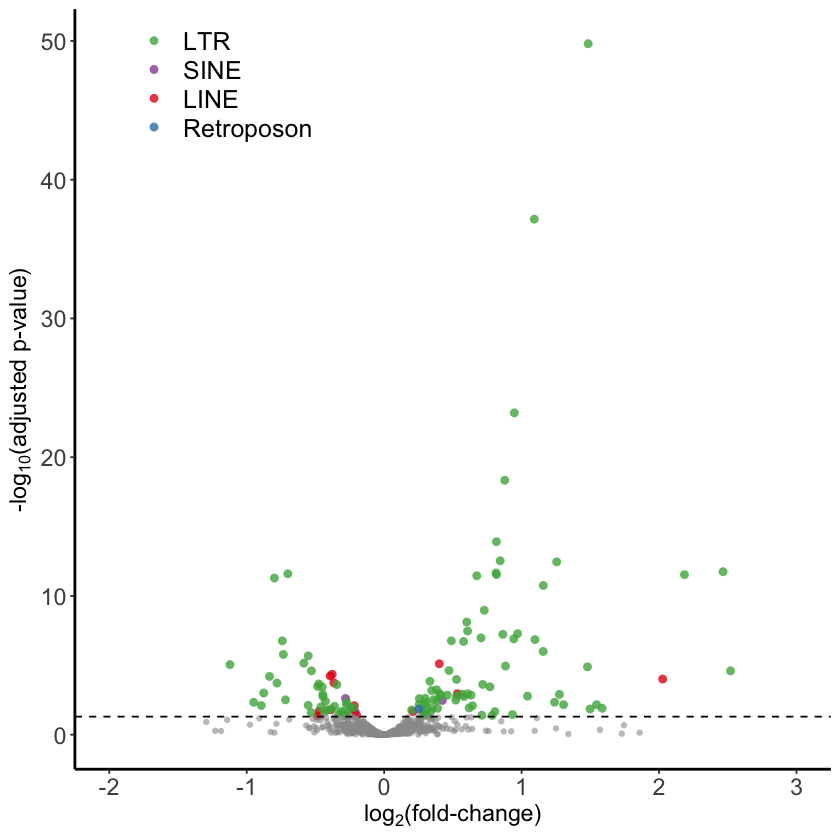

In [38]:
################################################################################
# Volcano plot
################################################################################

r = "#e41a1c"
b = '#377eb8'
g = "#4daf4a"
p = "#984ea3"

input = results_df_transcripts_ERE

input$class = factor(input$class, levels = c('LTR', 'SINE', 'LINE', 'Retroposon'))

volcano_plot = ggplot() +
  geom_point(data = subset(input, significant == TRUE), aes(x = log2FoldChange, y = -log10(padj), fill = class, color = class), size = 2.5, alpha = 0.8, shape = 21, stroke = 0) +
  geom_point(data = subset(input, significant == FALSE), aes(x = log2FoldChange, y = -log10(padj)), size = 1.8, shape = 16, stroke = 0, color = alpha('#9B9A99', 0.6)) +
  geom_hline(yintercept = -log10(0.05), linetype = 'dashed') +
  xlab(expression('log'[2]*'(fold-change)')) +
  ylab(expression('-log'[10]*'(adjusted p-value)')) +
  xlim(-2, 3) +
  scale_fill_manual(values = c(g, p, r, b)) +
  scale_colour_manual(values = c(g, p, r, b)) +
  labs(fill= "") +
  guides(color = F)

volcano_plot + theme_bw() + theme(plot.title = element_text(face = 'bold', size = 20),
                                  plot.subtitle = element_text(size = 14),
                                  axis.text.x = element_text(size = 14),
                                  axis.text.y = element_text(size = 14),
                                  axis.title = element_text(size = 14),
                                  axis.line = element_line(size = 0.8),
                                  panel.border = element_blank(),
                                  legend.text = element_text(size = 15),
                                  legend.title = element_text(size = 18),
                                  legend.position = c(0.2, 0.93),
                                  panel.grid.major = element_blank(),
                                  panel.grid.minor = element_blank())